In [1]:
import minari
import os
import h5py
import numpy as np
import torch
import matplotlib.pyplot as plt
import gymnasium as gym
import shimmy
from custom_dmc_tasks import point_mass_maze

from stable_baselines3 import TD3
from stable_baselines3.common.noise import NormalActionNoise

from torch.utils.data import Dataset, DataLoader
# os.environ['MUJOCO_GL'] = 'glfw'

In [2]:
task = 'reach_top_right'



# TD3 Training

In [69]:
def render_environment():
    raw_env = point_mass_maze.make(task=task)
    raw_env.reset()
    
    physics = raw_env.physics
    frame = physics.render(
            height=480, 
            width=480, 
            camera_id=0, 
            )

    plt.figure(figsize=(8, 8))
    plt.imshow(frame)
    plt.axis('off')
    plt.title("PointMass Maze")
    plt.show()


In [70]:
from stable_baselines3.common.vec_env import DummyVecEnv, VecMonitor

def make_env():
    raw_env = point_mass_maze.make(task=task)
    return shimmy.DmControlCompatibilityV0(raw_env)

# Замените SubprocVecEnv на DummyVecEnv
env = DummyVecEnv([make_env for _ in range(4)]) # Начните с 4, чтобы не забить память
env = VecMonitor(env)


policy_kwargs = dict(
    net_arch=dict(
        pi=[512, 512, 512],  # (Actor/Policy)
        qf=[512, 512, 512]   # (Critic/Q-function)
    )
)

model = TD3(
    "MultiInputPolicy",
    env,
    policy_kwargs=policy_kwargs,
    learning_rate=1e-4,      # КРИТИЧНО: уменьшаем по Таблице 8
    buffer_size=1_000_000,
    batch_size=256,         # По таблице (Common -> Batch Size)
    tau=0.005,                # Эквивалент EMA 0.99 (1 - 0.99)
    gamma=0.99,              # По таблице (Discount Factor)
    target_policy_noise=0.2, 
    target_noise_clip=0.3,
    policy_delay=2,          # Policy Update Frequency = 1
    verbose=1,
    device='cpu'
)


Using cpu device


In [ ]:
model.learn(total_timesteps=1500_000, progress_bar=True)

In [ ]:
model.save(f"td3_point_mass_expert_{task}")

In [7]:
import imageio
import numpy as np

def create_agent_gif(model_path="td3_point_mass_expert", gif_name="agent_trajectory.gif"):
    # 1. Инициализация (используем raw_env для доступа к физике)
    raw_env = point_mass_maze.make(task=task)
    env = shimmy.DmControlCompatibilityV0(raw_env) # Убираем render_mode отсюда
    
    model = TD3.load(model_path)
    
    obs, _ = env.reset()
    frames = []
    
    print("Запуск агента...")
    # 500 шагов — это 10 секунд при 0.02s шаге. 5000 — это слишком много для GIF.
    for _ in range(500): 
        # Рендерим напрямую из физики dm_control (самый надежный способ)
        frame = raw_env.physics.render(height=480, width=480, camera_id=0)
        frames.append(frame)
        
        action, _ = model.predict(obs, deterministic=True)
        obs, _, terminated, truncated, _ = env.step(action)
        
        if terminated or truncated:
            break

    if frames:
        # Важно: приводим к типу uint8 перед сохранением
        imageio.mimsave(gif_name, [np.array(f).astype(np.uint8) for f in frames], 
                        fps=30) # Используем fps вместо duration для предсказуемости
        print(f"GIF успешно сохранен: {gif_name}")
    else:
        print("Ошибка: кадры не были сгенерированы!")

if __name__ == "__main__":
    # Убедись, что переменная task определена (например, task = 'point_mass_maze')
    create_agent_gif(model_path=f"td3_point_mass_expert_{task}", 
                     gif_name=f"agent_trajectory_{task}.gif")

Запуск агента...

/Users/sgerasimov/Desktop/GenAI/TDFlow/.venv/lib/python3.11/site-packages/imageio/plugins/pillow.py:410: 
DeprecationWarning: The keyword `fps` is no longer supported. Use `duration`(in ms) instead, e.g. `fps=50` == 
`duration=20` (1000 * 1/50).
  warnings.warn(

GIF успешно сохранен: agent_trajectory_reach_bottom_right.gif

In [11]:
position_init = np.array([np.random.uniform(-0.29, -0.15), np.random.uniform(0.15, 0.29)])
velocity_init = np.array([0,0])
obs_init = np.concat([position_init, velocity_init], axis=-1)

# EMD & MSE(V)

In [3]:
import ot
from tqdm import tqdm

model_path = f"td3_point_mass_expert_{task}"

In [4]:
# raw_env = point_mass_maze.make(task=task)
# env = shimmy.DmControlCompatibilityV0(raw_env) # Убираем render_mode отсюда

model = TD3.load(model_path)

# states_batch = []
# frames_batch = []

In [5]:
from stable_baselines3.common.vec_env import DummyVecEnv, VecMonitor

def make_env():
    raw_env = point_mass_maze.make(task=task)
    return shimmy.DmControlCompatibilityV0(raw_env)

vec_env = DummyVecEnv([make_env for _ in range(1)])
vec_env = VecMonitor(vec_env)

In [6]:
from collections import OrderedDict
def force_set_state(vec_env, target_state):
    """
    target_state: np.array([x, y, vx, vy])
    """
    new_obs_list = []
    
    for e in vec_env.envs:
        # 1. Пробиваемся сквозь Monitor и Shimmy до dm_control Environment
        dmc_env = e.unwrapped._env 
        
        # 2. Вызываем метод у ТАСКИ (где вы его и определили)
        # Мы передаем physics, так как в классе Task.set_state он нужен первым аргументом
        dmc_env.task.set_state(dmc_env.physics, target_state)
        
        # 3. Сразу берем свежее наблюдение после телепортации
        obs_dict = dmc_env.task.get_observation(dmc_env.physics)
        
        # Конкатенируем в вектор (как ожидает ваша модель)
        flat_obs = np.concatenate([obs_dict['position'], obs_dict['velocity']])
        new_obs_list.append(flat_obs)
    new_obs_list = np.array(new_obs_list)
    return OrderedDict({'position':new_obs_list[:, :2], 'velocity': new_obs_list[:, 2:]})

def get_true_physics_state(vec_env, env_idx=0):
    # Достаем физику из конкретной среды внутри батча
    physics = vec_env.envs[env_idx].unwrapped.physics
    
    # qpos - это позиции (в PointMaze первые два - это x, y)
    true_pos = physics.data.qpos[:2].copy()
    # qvel - это скорости
    true_vel = physics.data.qvel[:2].copy()
    
    return OrderedDict({'position':true_pos, 'velocity': true_vel})

# Теперь используем это так:
obs = force_set_state(vec_env, target_state=np.array([-0.22865181,  0.23067307, 0.0, 0.0]))

In [7]:
obs

OrderedDict([('position', array([[-0.22865181,  0.23067307]])),
             ('velocity', array([[0., 0.]]))])

In [51]:
states = []
actions = []
trajectories = []
rewards = []
stopping_times = []
for n in tqdm(range(64)):
    obs = force_set_state(vec_env, target_state=np.array([-0.22865181,  0.23067307, 0.0, 0.0]))
    state = [np.concat([obs['position'], obs['velocity']], axis=-1)] # set initial state
    actions = [np.array([[0.0, 0.0]])] # set initial action
    obs, r, terminated, _ = vec_env.step(actions[0])
    state.append(np.concat([obs['position'], obs['velocity']], axis=-1))
    reward = [r]
    for t in range(1000): 
        # frame = raw_env.physics.render(height=480, width=480, camera_id=0)
        # frames.append(frame)
        
        action, _ = model.predict(obs, deterministic=True)
        obs, r, terminated, _ = vec_env.step(action)
        reward.append(r)
        if terminated:
            state.append(np.concat([obs['position'], obs['velocity']], axis=-1))
            break
        state.append(np.concat([obs['position'], obs['velocity']], axis=-1))
    
    T = np.minimum(np.random.geometric(1-0.99, 2048), len(state)-1)
    states.append(np.array(state)[T].squeeze())
    trajectories.append(state)
    rewards.append(reward)
    stopping_times.append(T)

100%|██████████| 64/64 [00:06<00:00,  9.23it/s]


In [67]:
def get_rewards_for_states(vec_env, states_batch):
    """
    states_batch: np.array (N, 4) - [x, y, vx, vy]
    """
    rewards = []
    dmc_env = vec_env.envs[0].unwrapped._env # Берем любой env из батча
    
    for s in states_batch:
        # 1. "Телепортируем" физику в нужное состояние (без шага!)
        with dmc_env.physics.reset_context():
            dmc_env.physics.data.qpos[:2] = s[:2]
            dmc_env.physics.data.qvel[:2] = s[2:]
        
        # 2. Вызываем расчет награды из Task
        rew = dmc_env.task.get_reward(dmc_env.physics)
        rewards.append(rew)
        
    return np.array(rewards)

In [ ]:
# MSE(V)
V_MC = sum([rewards[0][t]*0.99**(t) for t in range(len(rewards[0]))])

# V_m = 1/(1-gamma) E_{x~m(.|s0, a0)} [r(x)] r(x) = get_rewards_for_states(x)

In [83]:
states_batch = trajectories[1]
states_batch = np.concatenate(states_batch[1:], axis=0)

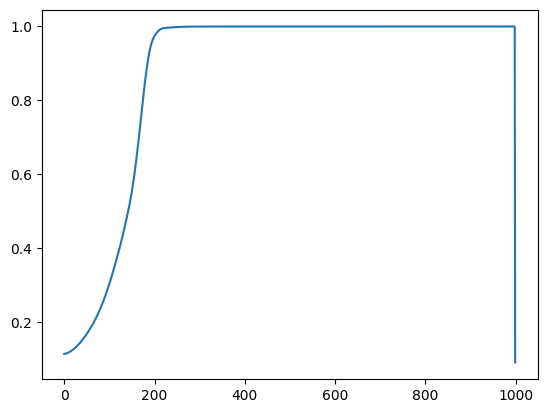

In [85]:
plt.plot(get_rewards_for_states(vec_env, states_batch))

In [ ]:
# EMD 
all_emds = []
for i in tqdm(range(1)):
    X_true = ... # sT
    X_pred = ... # samples from m
    M = ot.dist(X_true, X_pred, metric='euclidean')
    a, b = np.ones((2048,)) / 2048, np.ones((2048,)) / 2048
    value = ot.emd2(a, b, M)
    all_emds.append(value)

final_score = np.mean(all_emds)

100%|██████████| 1/1 [00:00<00:00,  6.30it/s]


In [41]:
final_score

np.float64(0.0041067043315321)